In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure

In [2]:
torch.manual_seed(1)

In [3]:
train_data = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_data = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_data),"\ntest_dataset size:", len(test_data))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1) # flatten as one dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def trainFunc(model,num_epochs,train_batch_size,status_interval): #define the training function
    model.train()
    print('started')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
           
            prediction = model(images)  # Forward pass

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

           
            
            loss.backward()  # Backward propagation 

            optimizer.step() #optimize

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True) #Print Status
        
       
        for name, parameter in model.named_parameters():
        
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()   #Weight Collection
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt

In [7]:
def testFunction(model,loss_func,test_batch_size):  #define test function
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [8]:
def pcaOps(paramDF,iteration):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),iteration)

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf

In [9]:
modelParam=[]
tempModel = DNN()
for i in tempModel.parameters():
    modelParam.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(modelParam)}')

Total no of parameters:418060


In [10]:
max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):

    j = DNN()  

    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    all_df = pd.concat([all_df, modelParamWgt])
    
    testAllacc[count] = testAcc
    trainAllacc[count] = trainAvgAccArr
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss


Time: 0
started
Time: 1y of the network on the test images: 98.06% & Test Loss: 0.06355487424880266
started
Time: 2y of the network on the test images: 98.02% & Test Loss: 0.06293453555554152
started
Time: 3y of the network on the test images: 98.0% & Test Loss: 0.06092536430805921
started
Time: 4y of the network on the test images: 98.01% & Test Loss: 0.06449411688372493
started
Time: 5y of the network on the test images: 97.87% & Test Loss: 0.0646446499042213
started
Time: 6y of the network on the test images: 98.11% & Test Loss: 0.059466106630861756
started
Time: 7y of the network on the test images: 98.04% & Test Loss: 0.06495909923687578
started


In [11]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])

In [12]:
all_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,8.407485e-03,3.342532e-05,-1.456931e-05,-1.231878e-05,5.416778e-05,3.672393e-03,5.604154e-04,4.590643e-04,1.064807e-02,-9.778960e-03,...,0.010879,-0.138834,0.063452,-0.071153,0.081553,1.380891e-01,-0.043701,-0.063947,0.040580,-0.141012
0,8.579916e-04,-7.691950e-06,3.082596e-05,1.864994e-07,2.536470e-06,-6.868089e-05,-7.803669e-06,-3.594813e-05,1.683690e-03,-1.337988e-03,...,0.002319,-0.150744,0.069631,-0.070653,0.088667,1.477040e-01,-0.058422,-0.069515,0.035073,-0.160353
0,-4.852979e-06,-6.665609e-07,-1.637773e-06,1.594748e-08,-1.883618e-08,1.961116e-06,-2.079887e-06,-1.123320e-06,7.284480e-05,-3.240416e-05,...,0.000802,-0.155301,0.071625,-0.070215,0.091023,1.527357e-01,-0.069927,-0.073286,0.033224,-0.176499
0,-8.169295e-07,3.363233e-08,-8.366516e-08,4.396322e-11,1.042210e-09,-1.770810e-07,5.613230e-08,-2.368325e-08,-2.996625e-06,2.475840e-06,...,-0.000724,-0.158225,0.073424,-0.070938,0.092652,1.566874e-01,-0.078413,-0.075999,0.032799,-0.188241
0,4.876665e-08,-1.464084e-09,-2.386475e-09,-4.365259e-11,-2.059961e-10,1.211540e-08,4.804912e-09,-1.310927e-09,3.535149e-08,-8.517949e-08,...,-0.001508,-0.161663,0.074814,-0.071883,0.093608,1.600455e-01,-0.085562,-0.079048,0.032833,-0.200799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,9.093373e-39,7.798453e-39,1.398656e-38,-3.655968e-39,1.243820e-38,5.136880e-39,-1.236789e-38,1.265829e-38,-1.037932e-38,9.809741e-39,...,0.123126,0.098290,-0.173330,0.077665,-0.275381,1.744208e-22,0.187032,-0.009185,0.020228,-0.078044
0,9.093373e-39,7.798453e-39,1.398656e-38,-3.655968e-39,1.243820e-38,5.136880e-39,-1.236789e-38,1.265829e-38,-1.037932e-38,9.809741e-39,...,0.124283,0.099084,-0.175216,0.078880,-0.277676,-7.662312e-24,0.188336,-0.009300,0.021196,-0.078836
0,9.093373e-39,7.798453e-39,1.398656e-38,-3.655968e-39,1.243820e-38,5.136880e-39,-1.236789e-38,1.265829e-38,-1.037932e-38,9.809741e-39,...,0.125168,0.099675,-0.177144,0.080137,-0.280346,3.779608e-25,0.189543,-0.009435,0.021952,-0.079521
0,9.093373e-39,7.798453e-39,1.398656e-38,-3.655968e-39,1.243820e-38,5.136880e-39,-1.236789e-38,1.265829e-38,-1.037932e-38,9.809741e-39,...,0.126472,0.100829,-0.178500,0.081766,-0.282299,-1.940416e-26,0.190715,-0.009462,0.023119,-0.080026


In [13]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')

Shape of Loss:(360,) & Shape of Acc: (360,)


In [14]:
print(pd.DataFrame(all_df))

             0             1             2             3             4    \
0   8.407485e-03  3.342532e-05 -1.456931e-05 -1.231878e-05  5.416778e-05   
0   8.579916e-04 -7.691950e-06  3.082596e-05  1.864994e-07  2.536470e-06   
0  -4.852979e-06 -6.665609e-07 -1.637773e-06  1.594748e-08 -1.883618e-08   
0  -8.169295e-07  3.363233e-08 -8.366516e-08  4.396322e-11  1.042210e-09   
0   4.876665e-08 -1.464084e-09 -2.386475e-09 -4.365259e-11 -2.059961e-10   
..           ...           ...           ...           ...           ...   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   
0   9.093373e-39  7.798453e-39  1.398656e-38 -3.655968e-39  1.243820e-38   

             5             6             7             8             9    ...  \
0   3.

In [15]:
t1 = np.array(all_df)
pca = PCA(n_components=2)
new_data = pca.fit_transform(all_df)
allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

allEpochDf

,x,y,Epoch,Iteration,Acc,Loss
0,3.326603,-2.596174,0,0,45.474434,1.297166
1,4.104606,-3.193014,1,0,87.930283,0.397275
2,4.626741,-3.585723,2,0,91.431844,0.294412
3,5.061860,-3.919600,3,0,92.737206,0.249932
4,5.439823,-4.207366,4,0,93.776543,0.215904
...,...,...,...,...,...,...
355,11.398404,7.277091,40,7,99.673536,0.019960
356,11.368053,7.257654,41,7,99.727405,0.018619
357,11.335653,7.239668,42,7,99.745770,0.017753
358,11.302396,7.217359,43,7,99.760190,0.017151


In [16]:
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

,x,y,Epoch,Iteration,Acc,Loss
0,4.626741,-3.585723,2,0,91.431844,0.294412
1,5.769581,-4.471245,5,0,94.409239,0.190290
2,6.511086,-5.066335,8,0,96.010152,0.138795
3,6.987495,-5.446976,11,0,97.002113,0.106105
4,7.317469,-5.701196,14,0,97.657159,0.084977
...,...,...,...,...,...,...
115,11.527890,7.362043,32,7,99.330032,0.030033
116,11.504027,7.343438,35,7,99.464995,0.025711
117,11.450281,7.312540,38,7,99.636195,0.022023
118,11.368053,7.257654,41,7,99.727405,0.018619


In [17]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

120

In [18]:
cmap = ['red','blue','purple','green','yellow','brown','black','grey']

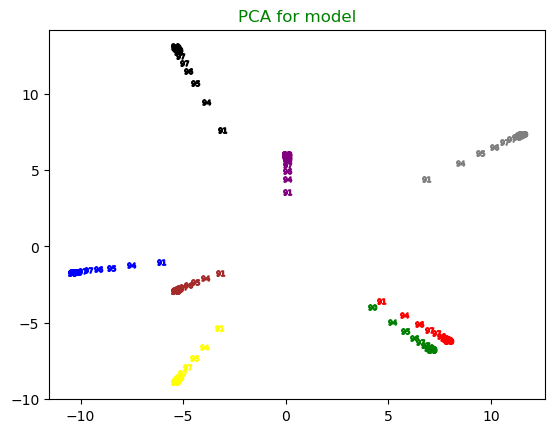

In [19]:
for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for model",color="g")
    
# plt.figure(figsize=[10,5],dpi=500)

plt.show()

In [20]:
layer1_Df = all_df.iloc[:,0:7840]

In [21]:
t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)

In [22]:
layer1Df = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data

layer1Df

,x,y,Epoch,Iteration,Acc,Loss
0,0.444406,0.334088,0,0,45.474434,1.297166
1,0.676166,0.424450,1,0,87.930283,0.397275
2,0.808308,0.484457,2,0,91.431844,0.294412
3,0.910761,0.531704,3,0,92.737206,0.249932
4,1.031274,0.562782,4,0,93.776543,0.215904
...,...,...,...,...,...,...
355,-0.244862,-0.349634,40,7,99.673536,0.019960
356,-0.248492,-0.347833,41,7,99.727405,0.018619
357,-0.243963,-0.341877,42,7,99.745770,0.017753
358,-0.242948,-0.341106,43,7,99.760190,0.017151


In [23]:
test = np.array(layer1Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))

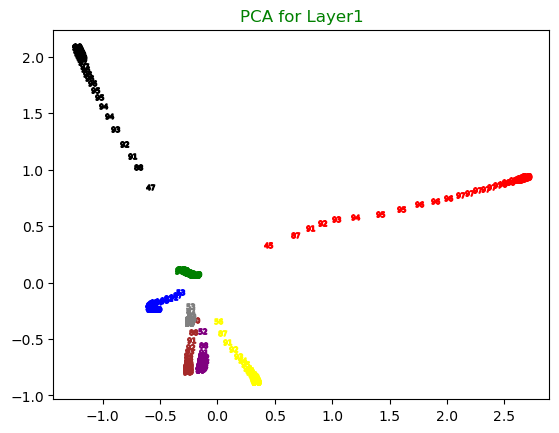

In [24]:
for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="g")


plt.show()